<a href="https://colab.research.google.com/github/erinmcmahon26/Image-Recognizer/blob/main/Image_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ingest Data

In [42]:
import os
import zipfile
import random
import datetime
from packaging import version
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image, display
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report 
from sklearn.metrics import roc_curve, auc

import sys
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, InputLayer, MaxPooling2D, Conv2D
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.callbacks import History 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

In [2]:
#!pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp ./drive/MyDrive/kaggle.json ~/.kaggle/

changes permissions on the files

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download dogs-vs-cats-redux-kernels-edition

100% 543M/544M [00:04<00:00, 130MB/s]
100% 544M/544M [00:04<00:00, 119MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 121MB/s]
 99% 268M/271M [00:05<00:00, 78.5MB/s]
100% 271M/271M [00:05<00:00, 54.3MB/s]


In [7]:
!unzip -q "./train.zip"
!unzip -q "./test.zip" 

### EDA

In [8]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [9]:
image = imread("./train/dog.1.jpg")

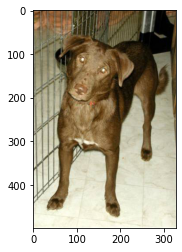

In [10]:
plt.imshow(image)
plt.show()

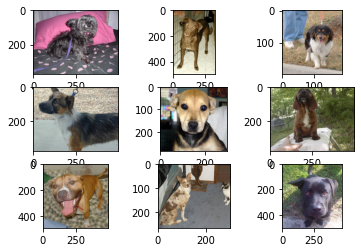

In [11]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

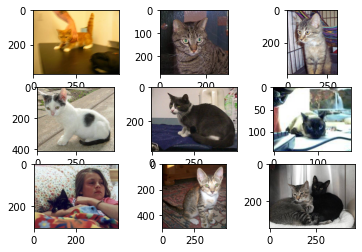

In [12]:
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [13]:
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

Splitting the training data into two folders to split up cat and dog images.

In [14]:
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [15]:
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

### Models

In [16]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [17]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.tight_layout(pad=3)
	pyplot.show()

In [18]:
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
	return history, model

#### One Block VGG

In [19]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 110s 341ms/step - loss: 0.6955 - accuracy: 0.5549 - val_loss: 0.6851 - val_accuracy: 0.5202
Epoch 2/10
293/293 [==============================] - 97s 330ms/step - loss: 0.6635 - accuracy: 0.5934 - val_loss: 0.6524 - val_accuracy: 0.6167
Epoch 3/10
293/293 [==============================] - 97s 333ms/step - loss: 0.6399 - accuracy: 0.6295 - val_loss: 0.6230 - val_accuracy: 0.6414
Epoch 4/10
293/293 [==============================] - 93s 318ms/step - loss: 0.6298 - accuracy: 0.6410 - val_loss: 0.6172 - val_accuracy: 0.6475
Epoch 5/10
293/293 [==============================] - 102s 348ms/step - loss: 0.6099 - accuracy: 0.6596 - val_loss: 0.6017 - val_accuracy: 0.6637
Epoch 6/10
293/293 [==============================] - 97s 332ms/step - loss: 0.5977 - accuracy: 0.6718 - val_loss: 0.5931 - val_accuracy: 0.6763
Epoch 7/10
293/293 [=======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  from ipykernel import kernelapp as app


99/99 [==============================] - 21s 215ms/step - loss: 0.5516 - accuracy: 0.7179
> 71.791


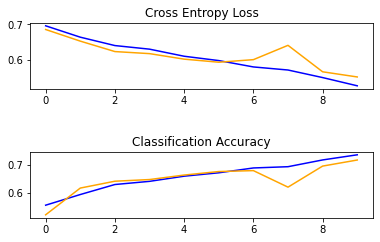

In [20]:
model_1_history, model_1 = run_test_harness()

In [48]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
val_test = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))

Found 6303 images belonging to 2 classes.


In [38]:
y_predict = model_1.predict_generator(val_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [39]:
y_predict = np.where(y_predict > 0.5, 1, 0)

In [40]:
p = val_test.classes
q = y_predict
p = np.array(p)
q = q.flatten()

[[1427 1755]
 [1373 1748]]


[Text(0, 0.5, 'cats'), Text(0, 1.5, 'dogs')]

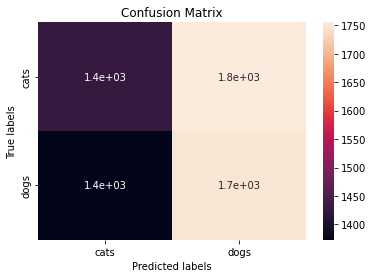

In [43]:
cfm = confusion_matrix(p, q)
print(cfm)
ax= plt.subplot()
sns.heatmap(cfm, annot=True, ax = ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['cats', 'dogs'])
ax.yaxis.set_ticklabels(['cats', 'dogs'])

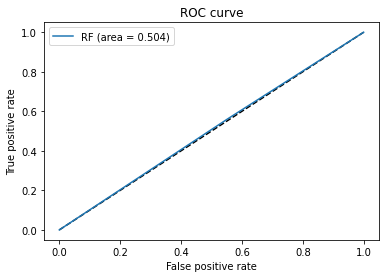

In [50]:
fpr, tpr, threshold = roc_curve(p,q)
auc_rf = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

This ROC curve and cm, I believe, are not representative of the accuracy of the model. It looks like I may not have done them correctly. Not sure what I'm messing up here. 

#### Two Block VGG

In [41]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/10
293/293 [==============================] - 94s 320ms/step - loss: 0.6863 - accuracy: 0.5586 - val_loss: 0.6615 - val_accuracy: 0.5829
Epoch 2/10
293/293 [==============================] - 94s 319ms/step - loss: 0.6428 - accuracy: 0.6191 - val_loss: 0.6178 - val_accuracy: 0.6545
Epoch 3/10
293/293 [==============================] - 95s 324ms/step - loss: 0.6047 - accuracy: 0.6642 - val_loss: 0.5824 - val_accuracy: 0.6949
Epoch 4/10
293/293 [==============================] - 94s 320ms/step - loss: 0.5610 - accuracy: 0.7054 - val_loss: 0.5445 - val_accuracy: 0.7254
Epoch 5/10
293/293 [==============================] - 93s 319ms/step - loss: 0.5242 - accuracy: 0.7350 - val_loss: 0.5238 - val_accuracy: 0.7447
Epoch 6/10
293/293 [==============================] - 94s 320ms/step - loss: 0.4828 - accuracy: 0.7722 - val_loss: 0.5081 - val_accuracy: 0.7517
Epoch 7/10
293/293 [==============================] - 94s 319ms/step - loss: 0.4532 - accuracy: 0.7875 - val_loss: 0.5015 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  from ipykernel import kernelapp as app


99/99 [==============================] - 22s 223ms/step - loss: 0.5091 - accuracy: 0.7563
> 75.631


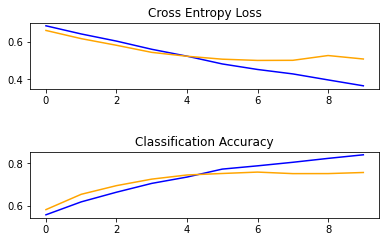

In [42]:
model_2_history, model_2 = run_test_harness()

#### Three Block VGG

In [43]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/10
293/293 [==============================] - 100s 337ms/step - loss: 0.6788 - accuracy: 0.5875 - val_loss: 0.6310 - val_accuracy: 0.6514
Epoch 2/10
293/293 [==============================] - 97s 331ms/step - loss: 0.6163 - accuracy: 0.6571 - val_loss: 0.5925 - val_accuracy: 0.6775
Epoch 3/10
293/293 [==============================] - 99s 337ms/step - loss: 0.5717 - accuracy: 0.7022 - val_loss: 0.5744 - val_accuracy: 0.6916
Epoch 4/10
293/293 [==============================] - 97s 332ms/step - loss: 0.5276 - accuracy: 0.7417 - val_loss: 0.5499 - val_accuracy: 0.7136
Epoch 5/10
293/293 [==============================] - 97s 332ms/step - loss: 0.4970 - accuracy: 0.7607 - val_loss: 0.5137 - val_accuracy: 0.7506
Epoch 6/10
293/293 [==============================] - 98s 334ms/step - loss: 0.4717 - accuracy: 0.7785 - val_loss: 0.4792 - val_accuracy: 0.7714
Epoch 7/10
293/293 [==============================] - 97s 332ms/step - loss: 0.4422 - accuracy: 0.7964 - val_loss: 0.4760 - val_a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  from ipykernel import kernelapp as app


99/99 [==============================] - 22s 224ms/step - loss: 0.4928 - accuracy: 0.7719
> 77.185


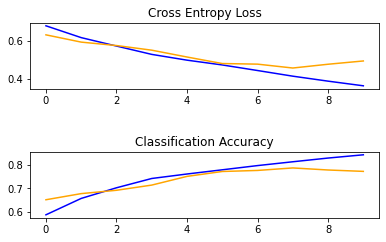

In [44]:
model_3_histroy, model_3 = run_test_harness()

### Conclusion

Model 3, a three block VGG, performed the best with 77% accuracy. Further model exploration is most likely needed for better accuracy. 

In [111]:
# create submission
datagen = ImageDataGenerator(rescale=1.0/255.0)
test = 'test/'
test = datagen.flow_from_directory('.', classes=['test'], batch_size=64, target_size=(200, 200))

Found 12500 images belonging to 1 classes.


In [120]:
preds3 = model_3.predict(x=test, steps=len(test), verbose=0)

In [150]:
predict_3 = pd.DataFrame(preds3)
predict_3.index.rename("id", inplace=True)
predict_3.index += 1
predict_3.rename(columns={0: 'label'}, inplace=True)

In [151]:
predict_3.head()

,label
id,
1,0.809445
2,0.850370
3,0.968647
4,0.763057
5,0.952029


In [152]:
predict_3.to_csv('model3.csv')

Additional Resources:

https://www.kaggle.com/kanishanand/dogs-vs-cats 

